In [283]:
import pandas as pd
import numpy as np
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.trading import TradingClient
from alpaca.trading.requests import GetCalendarRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.data.enums import Adjustment
# from datetime import date, datetime, timedelta
from datetime import datetime, date, time as datetime_time, timezone, timedelta
import pytz
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import toml
import os
from dotenv import load_dotenv

import time

load_dotenv(override=True)
livepaper = os.getenv('LIVEPAPER')
config = toml.load('../config.toml')

# Replace with your Alpaca API credentials
API_KEY = config[livepaper]['key']
API_SECRET = config[livepaper]['secret']


In [284]:
from datetime import datetime, timezone, timedelta

def to_datetime_with_timezone(date_str, tz_offset=0):
    """
    Converts a date string to a datetime object with specified timezone.

    :param date_str: The date string to convert (format: YYYY-MM-DD HH:MM:SS).
    :param tz_offset: The timezone offset in hours.
    :return: A datetime object representing the same date and time with specified timezone.
    """
    # Parse the date string to a datetime object
    
    datetime_obj = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S") if isinstance(date_str, str) else date_str
    
    # Create a timezone object with the specified offset
    timezone_obj = timezone(timedelta(hours=tz_offset))
    
    # Set the timezone for the datetime object
    datetime_obj = datetime_obj.replace(tzinfo=timezone_obj)
    
    return datetime_obj

# 2024-06-21 09:30:00 2024-06-21 16:00:00 <class 'datetime.datetime'>
# Example usage
# date_str = "2024-06-21 09:30:00"
# datetime_obj = to_datetime_with_timezone(date_str, tz_offset=0)

# print(datetime_obj)


In [285]:
dt_with_tz = datetime.now(pytz.timezone('US/Eastern'))

# Convert to the desired format
dt_str = str(dt_with_tz.strftime('%Y-%m-%d %H:%M:%S'))
dt_str

'2024-07-05 08:26:54'

In [286]:
def get_market_hours(dates):
    """
    Parameters:
    dates (list of str): List of dates in 'YYYY-MM-DD' format.

    Returns:
    dict: Dictionary with dates as keys and (market_open, market_close) tuples as values.
    """
    trading_client = TradingClient(API_KEY, API_SECRET)
    start_date = min(dates)
    end_date = max(dates)
    
    calendar_request = GetCalendarRequest(start=start_date, end=end_date)
    calendar = trading_client.get_calendar(calendar_request)
    
    market_hours = {str(day.date): (day.open, day.close) for day in calendar}
    return market_hours

In [327]:
def calculate_touch_detection_area(symbol, start_date, end_date, atr_period=10, multiplier=2, min_touches=2, bid_buffer_pct=0.005, sell_time=None, use_median=False):
    """
    Calculate the touch detection area based on custom volatility analysis and identify strong support and resistance levels,
    considering only market hours and selling all positions before a specified time.

    Parameters:
    symbol (str|list): The stock symbol to analyze.
    start_date (str|datetime): The start datetime for historical data (format: 'YYYY-MM-DD HH:MM:SS.%f').
    end_date (str|datetime): The end datetime for historical data (format: 'YYYY-MM-DD HH:MM:SS.%f').
    atr_period (int): The period for calculating Average True Range (ATR).
    multiplier (float): The multiplier for ATR to define the touch detection area width.
    min_touches (int): The minimum number of touches to consider a level as strong support or resistance.
    bid_buffer_pct (float): The percentage above the high or below the low to place a stop market buy.
    sell_time (str): The time to sell all positions before (format: 'HH:MM'). If None or after market close, defaults to market close.
    use_median (bool): Flag to switch between using mean or median for levels and touch areas.

    Returns:
    dict: A dictionary with support and resistance areas for both long and short positions.
    """
    # Alpaca API setup
    client = StockHistoricalDataClient(api_key=API_KEY, secret_key=API_SECRET)

    # Request historical data
    request_params = StockBarsRequest(
        symbol_or_symbols=symbol, # CAN be str or list. but set up for str (1 stock) for now)
        timeframe=TimeFrame.Minute,
        start=start_date if isinstance(start_date, datetime) else datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S.%f'),
        end=end_date if isinstance(end_date, datetime) else datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S.%f'),
        adjustment=Adjustment.ALL
    )
    bars = client.get_stock_bars(request_params)
    df = bars.df
    # print(pd.Series(list(df.index.get_level_values('timestamp').time)).value_counts().sort_index()) # gets trading hours range, including pre and post market
    
    
    # Calculate True Range (TR)
    df['H-L'] = df['high'] - df['low']
    df['H-PC'] = np.abs(df['high'] - df['close'].shift(1))
    df['L-PC'] = np.abs(df['low'] - df['close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    if use_median:
        df['MTR'] = df['TR'].rolling(window=atr_period).median()
    else:
        df['ATR'] = df['TR'].rolling(window=atr_period).mean()
        
    timestamps = df.index.get_level_values('timestamp')
    # Identify potential support and resistance levels
    potential_levels = defaultdict(list)
    for i in range(1, len(df) - 1):
        if df['low'].iloc[i] <= df['low'].iloc[i-1] and df['low'].iloc[i] <= df['low'].iloc[i+1]:
            potential_levels[df['low'].iloc[i]].append(timestamps[i])  # Extract timestamp
        if df['high'].iloc[i] >= df['high'].iloc[i-1] and df['high'].iloc[i] >= df['high'].iloc[i+1]:
            potential_levels[df['high'].iloc[i]].append(timestamps[i])  # Extract timestamp
    
    strong_levels = {level: touches for level, touches in potential_levels.items() if len(touches) >= min_touches}

    central_value = df['close'].median() if use_median else df['close'].mean()
    
    # Define the upper and lower bounds for the touch areas
    support_levels = {level: touches for level, touches in strong_levels.items() if level <= central_value}
    resistance_levels = {level: touches for level, touches in strong_levels.items() if level > central_value}
    
    
    unique_dates = pd.unique(timestamps.date)
    timestamps = timestamps.strftime('%Y-%m-%d %H:%M:%S')
    date_strs = [str(date) for date in unique_dates]
    market_hours = get_market_hours(date_strs)
    
    if sell_time:
        sell_time = datetime.strptime(sell_time, '%H:%M')
        
    widths = []

    def calculate_touch_area(levels, is_long):
        touch_areas = []
        for level, touches in levels.items():
            n = len(touches)
            if n < min_touches:
                continue
            first_touch_price = df.loc[(symbol, touches[0]), 'close']
            # price_range = df.loc[(symbol, touches), 'high'].max() - df.loc[(symbol, touches), 'low'].min()
            
            # # Calculate ATR or Median TR based on the flag
            # if use_median:
            #     touch_area_width = df.loc[(symbol, touches[0]), 'MTR'] * multiplier # OR median of [df.loc[(symbol, touches[a]), 'MTR'] for a in touches] * multiplier
            # else:
            #     touch_area_width = df.loc[(symbol, touches[0]), 'ATR'] * multiplier # OR avg of [df.loc[(symbol, touches[a]), 'MTR'] for a in touches] * multiplier
                
            if use_median:
                touch_area_width = np.mean([df.loc[(symbol, a), 'MTR'] for a in touches]) * multiplier
            else:
                touch_area_width = np.mean([df.loc[(symbol, a), 'ATR'] for a in touches]) * multiplier

            if np.isnan(touch_area_width):
                continue
            
            widths.append(touch_area_width)
            
            # lower_bound = first_touch_price - (2 * price_range / 3) if is_long else first_touch_price - (price_range / 3)
            # upper_bound = first_touch_price + (price_range / 3) if is_long else first_touch_price + (2 * price_range / 3)
            lower_bound = first_touch_price - (2 * touch_area_width / 3) if is_long else first_touch_price - (touch_area_width / 3)
            upper_bound = first_touch_price + (touch_area_width / 3) if is_long else first_touch_price + (2 * touch_area_width / 3)
            

            # Filter touches based on market hours and sell_time
            filtered_touches = []

            # for i in range(min_touches): # only need up to min_touches?
            for i in range(n):
                touch_time = touches[i]
                
                # touch_time is timezone aware. converting to unaware to work with market_open and market_close
                touch_time = datetime.strptime(str(touch_time.strftime('%Y-%m-%d %H:%M:%S')), "%Y-%m-%d %H:%M:%S")
                touch_date = touch_time.date()
                market_open, market_close = market_hours.get(str(touch_date), (None, None))
                if sell_time:
                    market_close = min(
                        datetime.strptime(str(touch_date), '%Y-%m-%d') + timedelta(hours=sell_time.hour, minutes=sell_time.minute),
                        market_close - timedelta(minutes=3)
                                    )
                if market_open and market_open <= touch_time <= market_close:
                    filtered_touches.append(touch_time)
            
            if filtered_touches:
                touch_areas.append((level, upper_bound, lower_bound, filtered_touches, first_touch_price))
        return touch_areas

    long_touch_area = calculate_touch_area(resistance_levels, True)
    short_touch_area = calculate_touch_area(support_levels, False)
    # print(len(long_touch_area), len(short_touch_area))
    
    widths = pd.Series(widths)
    print(widths.describe())
    print(widths.isna().value_counts())
    
    final_mask = pd.Series(False, index=df.index)
    for date in unique_dates:
        market_open, market_close = market_hours.get(str(date), (None, None))
        date = datetime.strptime(str(date), '%Y-%m-%d')
        if market_open is None or market_close is None:
            market_open = market_close = date
        elif sell_time:
            market_close = date + timedelta(hours=sell_time.hour, minutes=sell_time.minute)
        mask = (timestamps >= str(market_open)) & (timestamps <= str(market_close))
        final_mask |= mask

    return {
        'long_touch_area': long_touch_area,
        'short_touch_area': short_touch_area,
        'market_hours': market_hours,
        'bars': df,
        'mask': final_mask,
        'bid_buffer_pct': bid_buffer_pct,
        'min_touches': min_touches,
        'sell_time': sell_time,
        'use_median': use_median
    }

In [328]:
def plot_touch_detection_areas(touch_detection_areas, symbol, save_path=None):
    long_touch_area = touch_detection_areas['long_touch_area']
    short_touch_area = touch_detection_areas['short_touch_area']
    market_hours = touch_detection_areas['market_hours']
    df = touch_detection_areas['bars']
    mask = touch_detection_areas['mask']
    bid_buffer_pct = touch_detection_areas['bid_buffer_pct']
    min_touches = touch_detection_areas['min_touches']
    sell_time = touch_detection_areas['sell_time']
    use_median = touch_detection_areas['use_median']

    # 
    plt.figure(figsize=(14, 7))
    plt.plot(df.index.get_level_values('timestamp'), df['close'], label='Close Price', color='blue') # before applying mask, plot the full chart
    
    # print(pd.Series(list(df.index.get_level_values('timestamp').time)).value_counts().sort_index())
    df = df[mask]
    timestamps = df.index.get_level_values('timestamp')

    # Fetch market hours for the relevant dates
    # timestamps = timestamps.strftime('%Y-%m-%d %H:%M:%S')
    # timestamps = timestamps.to_pydatetime()
    
    timestamps_set = {a.replace(tzinfo=None) for a in timestamps}

    def get_touch_area_end_idx(start_idx, bound, is_long=True, touch_time=None):
        # Determine the date of the touch event
        touch_date = touch_time.date()
        
        # Fetch market open and close times for the given date
        market_open, market_close = market_hours.get(str(touch_date), (None, None))
        
        # If a sell time is specified, adjust the market close time to be the sell time or slightly before the actual market close
        if sell_time:
            market_close = min(
                datetime.strptime(str(touch_date), '%Y-%m-%d') + timedelta(hours=sell_time.hour, minutes=sell_time.minute),
                market_close - timedelta(minutes=3)
            )
        
        # Iterate through the DataFrame from the start index to find the sell time index
        for i in range(start_idx, len(df)):
            # Remove timezone information from the current timestamp for comparison
            current_time = timestamps[i].replace(tzinfo=None)
            
            # If the current time exceeds the adjusted market close time, return the previous index
            if current_time > market_close:
                return i - 1
            
            # If the price exceeds the bound for long positions or falls below the bound for short positions, return the current index
            if (is_long and df['close'].iloc[i] > bound * (1 + bid_buffer_pct / 100)) or (not is_long and df['close'].iloc[i] < bound * (1 - bid_buffer_pct / 100)):
                return i
        
        # If no appropriate index is found, return the last index of the DataFrame
        return len(df) - 1

    def plot_area(area, is_long=True):
        
        level, upper_bound, lower_bound, touches, central_value = area
        n = len(touches) 
        if n < min_touches: # omit if min_touches not met
            return

        mark_pos = upper_bound if is_long else lower_bound
        mark_shape = "v" if is_long else '^'
        
        for i, touch_time in enumerate(touches):
            if touch_time in timestamps_set:
                start_idx = timestamps.get_loc(str(touch_time))
                end_idx = get_touch_area_end_idx(start_idx, upper_bound if is_long else lower_bound, is_long, touch_time)
                x = [timestamps[start_idx], timestamps[end_idx]]
                # if end_idx == start_idx:
                #     print(x)
                    
                # if n < min_touches:
                #     print(x)
                if i != min_touches - 1: 
                    pass
                    # if end_idx == start_idx:
                    #     plt.scatter(touch_time, mark_pos, color='orange', s=12, marker=mark_shape)
                    # elif end_idx != start_idx:
                    #     plt.scatter(touch_time, mark_pos, color='black', s=12, marker=mark_shape)
                else: # min_touches met
                    if end_idx == start_idx:
                        plt.scatter(touch_time, mark_pos, color='red', s=12, marker=mark_shape)
                    else:
                        plt.scatter(touch_time, mark_pos, color='blue', s=12, marker=mark_shape)
                
                if i == 0: # first touch
                    color = 'red' if is_long else 'green'
                    plt.fill_between(x, lower_bound, upper_bound, color=color, alpha=0.3)
                    # print(x, central_value, lower_bound, upper_bound)
                    plt.plot(x, [central_value, central_value], color='blue', linestyle='-')

    for area in long_touch_area:
        plot_area(area, is_long=True)

    for area in short_touch_area:
        plot_area(area, is_long=False)

    plt.title(f'{symbol} Price Chart with Touch Detection Areas')
    plt.xlabel('Date')
    plt.ylabel('Price')
    # plt.legend(['Close Price', 'Long Touch Area', 'Short Touch Area'])
    plt.legend().remove()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path)

    plt.show()

count    591.000000
mean       0.343956
std        0.116365
min        0.045625
25%        0.265131
50%        0.336237
75%        0.416579
max        0.808333
dtype: float64
False    591
Name: count, dtype: int64


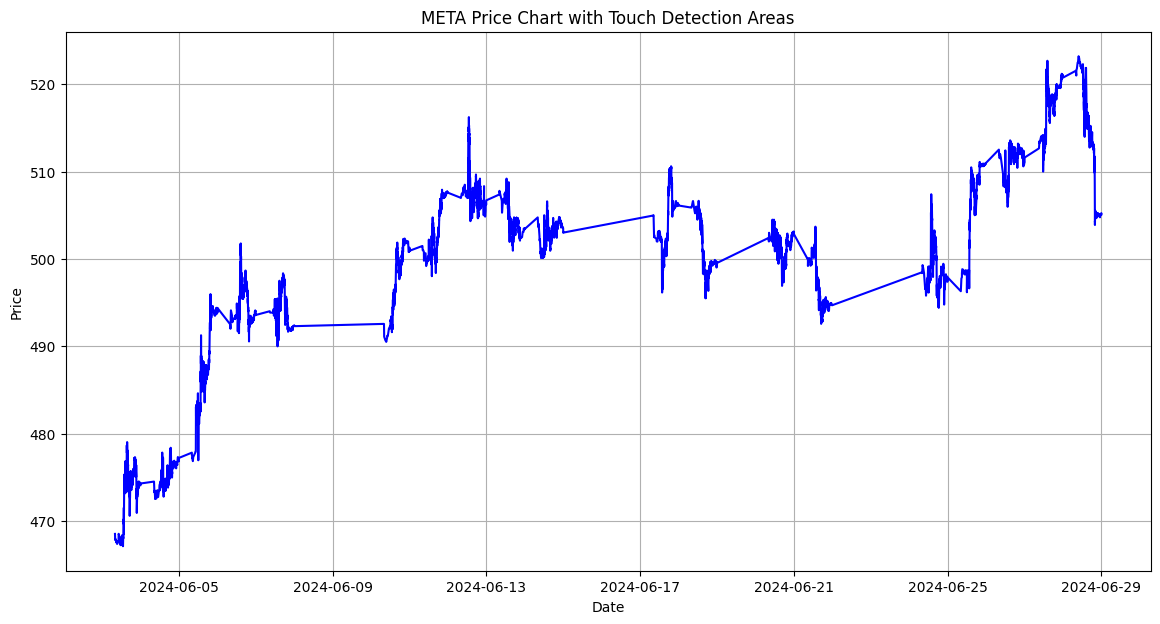

In [367]:
# symbol = "NVDA"
symbol = "META"

# start_date=datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S%z'),
# end=datetime.strptime("2023-12-02 00:00:00+00:00" , '%Y-%m-%d %H:%M:%S%z').str
# '2024-07-03 02:15:18.202708'
# start_date = datetime.strptime("2024-06-21 9:00:00.0", '%Y-%m-%d %H:%M:%S.%f')

# end_date = start_date + timedelta(hours=12)

# end_date = "2023-12-02 00:00:00.0" 

# start_date = datetime.today() - timedelta(hours=36)
# end_date = datetime.today()
start_date = "2024-06-01 08:00:00.0"
end_date = "2024-06-30 16:00:00.0"
# min_touches = 3
touch_detection_areas = calculate_touch_detection_area(symbol, start_date, end_date, atr_period=30, multiplier=1, min_touches=3, sell_time='16:00', use_median=True)
plot_touch_detection_areas(touch_detection_areas, symbol)

In [368]:
def backtest_strategy(touch_detection_areas, initial_investment=10000):
    df = touch_detection_areas['bars']
    long_touch_area = touch_detection_areas['long_touch_area']
    short_touch_area = touch_detection_areas['short_touch_area']
    market_hours = touch_detection_areas['market_hours']
    bid_buffer_pct = touch_detection_areas['bid_buffer_pct']
    min_touches = touch_detection_areas['min_touches']
    sell_time = touch_detection_areas['sell_time']
    timestamps = df.index.get_level_values('timestamp')

    balance = initial_investment
    trades_executed = 0

    def get_touch_area_end_idx(start_idx, bound, is_long=True, touch_time=None):
        # Determine the date of the touch event
        touch_date = touch_time.date()
        
        # Fetch market open and close times for the given date
        market_open, market_close = market_hours.get(str(touch_date), (None, None))
        
        # If a sell time is specified, adjust the market close time to be the sell time or slightly before the actual market close
        if sell_time:
            market_close = min(
                datetime.strptime(str(touch_date), '%Y-%m-%d') + timedelta(hours=sell_time.hour, minutes=sell_time.minute),
                market_close - timedelta(minutes=3)
            )
        
        # Iterate through the DataFrame from the start index to find the sell time index
        for i in range(start_idx, len(df)):
            # Remove timezone information from the current timestamp for comparison
            current_time = timestamps[i].replace(tzinfo=None)
            
            # If the current time exceeds the adjusted market close time, return the previous index
            if current_time > market_close:
                return i - 1
            
            # If the price exceeds the bound for long positions or falls below the bound for short positions, return the current index
            if (is_long and df['close'].iloc[i] > bound * (1 + bid_buffer_pct / 100)) or (not is_long and df['close'].iloc[i] < bound * (1 - bid_buffer_pct / 100)):
                return i
        
        # If no appropriate index is found, return the last index of the DataFrame
        return len(df) - 1

    def execute_trade(start_idx, stop_price, is_long):
        nonlocal balance, trades_executed
        shares = balance / df['close'].iloc[start_idx]
        max_price = df['close'].iloc[start_idx]
        min_price = df['close'].iloc[start_idx]
        
        for i in range(start_idx + 1, len(df)):
            current_price = df['close'].iloc[i]
            if is_long:
                max_price = max(max_price, current_price)
                trailing_stop_price = max_price * (1 - bid_buffer_pct / 100)
                if current_price <= trailing_stop_price:
                    balance = shares * trailing_stop_price
                    trades_executed += 1
                    break
            else:
                min_price = min(min_price, current_price)
                trailing_stop_price = min_price * (1 + bid_buffer_pct / 100)
                if current_price >= trailing_stop_price:
                    balance = shares * trailing_stop_price
                    trades_executed += 1
                    break
        else:
            balance = shares * df['close'].iloc[-1]
            trades_executed += 1

    timestamps_set = {a.replace(tzinfo=None) for a in timestamps}
    
    def process_touch_areas(touch_areas, is_long):
        for area in touch_areas:
            level, upper_bound, lower_bound, touches, central_value = area
            for i, touch_time in enumerate(touches):
                if i == min_touches - 1:
                    if touch_time in timestamps_set:
                        start_idx = timestamps.get_loc(str(touch_time))
                        end_idx = get_touch_area_end_idx(start_idx, upper_bound if is_long else lower_bound, is_long, touch_time)
                        stop_price = df['close'][end_idx]
                        
                        execute_trade(end_idx, stop_price, is_long)

    # Process long and short touch areas
    process_touch_areas(long_touch_area, is_long=True)
    process_touch_areas(short_touch_area, is_long=False)

    percent_increase = ((balance - initial_investment) / initial_investment) * 100

    # Buy and hold strategy
    start_price = df['close'].iloc[0]
    end_price = df['close'].iloc[-1]
    buy_and_hold_increase = ((end_price - start_price) / start_price) * 100

    # Print statistics
    print('Initial Investment:', initial_investment)
    print('Current Balance:', balance)
    print('Net:', balance - initial_investment)
    print(f"Percent increase: {percent_increase:.2f}%")
    print(f"Buy and Hold percent increase: {buy_and_hold_increase:.2f}%")
    print('Number of Trades Executed:', trades_executed)

    
print(symbol)
backtest_strategy(touch_detection_areas)


META
Initial Investment: 10000
Current Balance: 10000
Net: 0
Percent increase: 0.00%
Buy and Hold percent increase: 7.81%
Number of Trades Executed: 0
